### Deep Learning Supervised Text Classification
- BiLSTM (no data augmentation)

Bidirectional recurrent neural networks (RNN) put two independent RNNs together. This structure allows the networks to have both backward and forward information about the sequence at every time step


### Prepare Environment

In [1]:
from numpy.random import seed
seed(156)
import tensorflow as tf
tf.random.set_seed(256)
print('Tensforflow version ' + tf.__version__)

Tensforflow version 2.9.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/safety_report_tc

/content/drive/MyDrive/Colab_Notebooks/safety_report_tc


In [ ]:
# Importing required libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm.std import tqdm
from IPython.display import display, HTML
from collections import Counter
import time
import textwrap
import json
import datetime
import pickle

### Load Data

In [ ]:
# Pick a minority category of interest (base data from source)
focus_cats = [
    'hydraulic fluid or oil leak',
    'line strike',
    'site compliance or practice issue',
    'ppe non-compliance',
    'mechanical or equipment issue'
    ]

fns = [
    '2209031206', # hydraulic fluid or oil leak
    '2210031444', # line strike
    '2210150857', # site compliance or practice issue, previous was 2210031122
    '2210031323', # ppe non-compliance
    '2210032046'  # mechanical or equipment issue
]

# Select a category to load
pick = input('Pick a category: ')
index = focus_cats.index(pick)
focus_cat = focus_cats[index]
fn = fns[index]
fn = f'01_data/prepared/{fn}_prepared_{focus_cat}_data.csv'

# Load data from a minority category of interest
df = pd.read_csv(fn)
df = df[['text', 'category']]
df = pd.read_csv(fn)
df

Pick a category: hydraulic fluid or oil leak


,text,category
0,foreign body entered employee l eye while grin...,0
1,drainage pipe damaged at twenty-two m depth se...,0
2,robodrill spider excavator being operated when...,1
3,pressure hose made contact with light fitting ...,0
4,nacap 30t hitachi hyd hose split resultong in ...,0
...,...,...
93852,fall on water vehicle an employee was using an...,0
93853,other fall to lower level unspecified an emplo...,0
93854,injured by slipping or swinging object held by...,0
93855,direct exposure to electricity greater than tw...,0


### Data Preparation (Train / Test Splits)

In [ ]:
# Now create the input to the model training stage
X = df.text
y = df.category # Remember, these are not necessarily the 'truth' but rule_book hits

# Apply a simple 80/20 split
# TODO - The dataset is heavily imbalanced. Treat this appropriately.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234, stratify=y)

In [ ]:
base_train_count = len(X_train)
base_train_count

75085

In [ ]:
test_trues = list(y_test[y_test==1].index.values)
test_trues.sort()
print('Test:', len(test_trues), test_trues)

train_trues = list(y_train[y_train==1].index.values)
train_trues.sort()
print('Train:', len(train_trues), train_trues)

Test: 115 [82, 235, 343, 443, 1024, 1537, 1546, 1556, 1812, 1883, 2041, 2131, 2370, 2403, 2555, 2966, 3372, 3526, 3545, 3748, 3861, 4102, 4155, 4297, 4529, 4714, 4798, 4859, 4883, 5117, 5763, 6275, 6354, 6463, 7207, 7237, 7807, 7838, 7969, 8017, 8177, 8249, 8794, 8855, 8911, 8960, 9061, 9179, 9288, 9596, 9659, 9826, 10152, 10337, 10365, 11026, 11689, 11716, 12118, 12217, 12261, 12666, 12823, 12829, 14490, 14823, 15166, 15310, 15318, 16095, 16404, 16722, 17262, 18669, 20952, 21682, 21735, 21919, 22492, 22993, 23057, 23099, 23358, 23426, 23892, 24007, 24310, 24361, 24487, 24548, 24556, 25862, 26267, 29548, 31724, 32377, 34391, 48304, 50966, 53906, 61714, 67893, 68518, 69153, 76134, 77874, 78010, 78673, 82479, 83196, 83854, 84247, 85984, 86281, 87933]
Train: 462 [2, 17, 24, 46, 143, 151, 237, 241, 273, 355, 404, 454, 490, 514, 518, 534, 548, 751, 813, 897, 994, 1188, 1296, 1373, 1399, 1401, 1418, 1461, 1513, 1531, 1558, 1559, 1587, 1678, 1684, 1704, 1750, 1754, 1774, 1857, 1960, 1965, 204

In [ ]:
# Calculate imbalance in test dataset
imb = round(100* (Counter(y_test)[1] / Counter(y_test)[0]), 2)
print(f'"{focus_cat}"')
print(Counter(y_test))
print(f'Test data imbalance: {imb}%')

"hydraulic fluid or oil leak"
Counter({0: 18657, 1: 115})
Test data imbalance: 0.62%


In [ ]:
# Look at training 'trues', i.e., rule-book hits
df_train_trues = df.iloc[train_trues]
df_train_trues.to_csv(f'01_data/prepared/df_train_trues_{focus_cat}.csv')
df_train_trues

,text,category
2,robodrill spider excavator being operated when...,1
17,spill to grade from grader pp103 at wpb angore...,1
24,fuel red diesel spilled onto whiterockdirt sur...,1
46,oil leak from crane that was on site for plann...,1
143,small oil spill on twenty-one thousand and twe...,1
...,...,...
90259,struck by discharged object or substance an em...,1
90458,injured by slipping or swinging object held by...,1
90618,struck by swinging part of powered vehicle an ...,1
91361,caught in running equipment or machinery durin...,1


## Build Model

In [ ]:
# Load modelling building libraries
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import warnings
import logging
logging.basicConfig(level=logging.INFO)

In [ ]:
# Create a function to prepare model input sequences and embedding dictionary
def prepare_model_input(X_train, X_test, MAX_NB_WORDS=75000, MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    all_text = np.concatenate((X_train, X_test), axis=0)
    all_text = np.array(all_text)

    # Fit tokeniser only on training text
    text = np.array(X_train)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)

    # Save the tokenizer as .pkl file
    pickle.dump(tokenizer, open(f'08_output/{time.strftime("%y%m%d%H%M")}_text_tokenizer.pkl', 'wb'))

    # Generate sequences for all text using tokenizer created only on training text
    # This converts the sentence into a sequence of integers, e.g., [2, 4, 5, 7]
    sequences = tokenizer.texts_to_sequences(all_text)

    # Get a list of all words and their sequence numbers
    word_index = tokenizer.word_index

    # Pad out the sequences with zeroes to max sequence length
    all_text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    # Seperate training sequences from test
    X_train_Glove = all_text[0:len(X_train), ]
    X_test_Glove = all_text[len(X_train):, ]

    # Now gather the embeddings
    # Start with standard GloVe
    ## https://www.google.com/search?client=safari&rls=en&q=glove+embeddings&ie=UTF-8&oe=UTF-8
    embeddings_dict = {}
    f = open("03_embeddings/glove/glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)


In [ ]:
# Create a function that builds the deep learning model
def build_bilstm(word_index, embeddings_dict, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5, hidden_layer = 3, lstm_node = 32):
    # Initialize a sequential model
    model = Sequential()
    
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer

    # Note
    # ====
    # Embedding layer is a compression of the input, when the layer is smaller (say less than 50), 
    # you compress more and lose more data. When the layer is bigger (say greater than 50) you 
    # compress less and potentially overfit your input dataset to this layer making it useless.
    # The larger vocabulary you have you want better representation of it - make the layer larger.
    # If you have very sparse documents relatively to the vocabulary, then you want to "get rid" 
    # of unnecessary and noisy words - you should compress more - make the embedding smaller.

    print('_words', len(word_index))
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    # Add hidden layers 
    # Default will be 3 layers
    # Default lstm nodel number will be 32
    for i in range(0, hidden_layer):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(lstm_node, return_sequences=True, recurrent_dropout=0.2)))

        # Add a dropout layer after each lstm layer
        model.add(Dropout(dropout))

    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))

    # Attention addition
    #model.add(attention(return_sequences=True))
    
    model.add(Dropout(dropout))

    # Add the fully connected layer with 256 nuerons & Relu activation
    model.add(Dense(256, activation='relu'))

    # Add the output layer with softmax activation (binary output)
    model.add(Dense(nclasses, activation='softmax'))

    # Compile the model using sparse_categorical_crossentropy
    model.compile(loss='sparse_categorical_crossentropy', #'BinaryCrossentropy',
                      optimizer='adam',
                      metrics=["categorical_accuracy"])
    return model

In [ ]:
print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train, X_test)
print("Done!")

Preparing model input ...
Total 400000 word vectors.
Done!


In [ ]:
len(X_train_Glove[0])

500

In [ ]:
X_train_Glove[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [ ]:
embeddings_dict["question"]

array([ 0.19854  ,  0.23367  , -0.13229  , -0.031831 ,  0.88523  ,
        0.3204   ,  0.084608 ,  0.14071  , -0.2259   , -0.22972  ,
       -0.65407  ,  0.16478  , -0.45206  , -0.042035 ,  0.95613  ,
        0.44857  ,  0.23103  , -0.38818  ,  0.45169  , -0.37423  ,
       -0.16046  ,  0.35678  ,  0.21063  ,  0.11357  ,  0.8986   ,
       -2.338    , -0.51544  ,  0.25484  ,  0.21606  , -0.10982  ,
        2.6156   , -0.098636 , -0.56122  , -0.88471  , -0.17587  ,
       -0.61716  , -0.27264  ,  0.050048 , -0.19554  , -0.29152  ,
       -0.22575  ,  0.22981  ,  0.10951  ,  0.9937   , -0.37194  ,
        0.23874  ,  0.12534  ,  1.2378   , -0.0029151,  0.27317  ],
      dtype=float32)

In [ ]:
len(embeddings_dict["question"])

50

In [ ]:
print("Building Model!")
model = build_bilstm(word_index, embeddings_dict, 2)
model.summary()

Building Model!
_words 58984
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 50)           2949250   
                                                                 
 bidirectional (Bidirectiona  (None, 500, 64)          21248     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 500, 64)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 500, 64)          24832     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 500, 64)           0         
                                                                 
 bidirectional_2 (Bidirecti

In [ ]:
# Quick view of rule_book hits (should represent the focus category)
X_test[y_test == 1].iloc[0]

'contact with objects and equipment unspecified an employee was trying to turn on an electric fan used by employees working on the line when he was struck by a door carrier the door carrier then pushed him into a steel guard'

### Model Training & Evaluatrion

In [ ]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "true positive": tp,
        "true negative": tn,
        "false positive": fp,
        "false negative": fn,
        "precision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


In [ ]:
# Split training into training and validation data
X_train_vGlove, X_val_Glove, y_vtrain, y_val = train_test_split(X_train_Glove, y_train, test_size = 0.1, stratify=y_train, random_state = 1234)

# Verify stratification
num_pos_vTrain = len(y_vtrain[y_vtrain==1])
print(f'Number of positives in training (val) split: {num_pos_vTrain}')

num_pos_val = len(y_val[y_val==1])
print(f'Number of positives in validation data: {num_pos_val}')

Number of positives in training (val) split: 288
Number of positives in validation data: 32


In [ ]:
train_or_load = input('Train new model (n) or load existing (l):')
if train_or_load == 'n':
    # Train the model
    def format_time(elapsed):
        return str(datetime.timedelta(seconds=int(round((elapsed)))))

    total_t0 = time.time()
    print('Training for:', focus_cat)
    epoch_num = int(input('Enter epoch number (default is 3): '))
    history = model.fit(X_train_vGlove, y_vtrain,
                                validation_data=(X_val_Glove, y_val),
                                epochs=epoch_num,
                                batch_size=128,
                                verbose=1)
    
    print(f'\nTotal training took {format_time(time.time()-total_t0)}')

    # Plot training history
    plot_graphs(history, 'loss')
else:
    # load the model from disk
    fname = input('Specify filename (without extension):')
    filename = f'08_output/models/{fname}.pkl'
    model = pickle.load(open(filename, 'rb'))

Train new model (n) or load existing (l):l
Specify filename (without extension):2210061200_line strike_bilstm_3_model


In [ ]:
Counter(y_test)

Counter({0: 18707, 1: 65})

In [ ]:
# Print accuracy measures
print(f'\n Evaluating Model for "{focus_cat}"... \n')

predicted = model.predict(X_test_Glove)
predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_test, predicted))
print("\n")
logger = logging.getLogger("logger")
result = compute_metrics(y_test, predicted)
for key in (result.keys()):
    logger.info("  %s = %s", key, str(result[key]))


 Evaluating Model for "line strike"... 

587/587 [==============================] - 241s 407ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18707
           1       0.38      0.35      0.37        65

    accuracy                           1.00     18772
   macro avg       0.69      0.68      0.68     18772
weighted avg       1.00      1.00      1.00     18772





In [ ]:
# Create dataframe for inspection of results
tmp = pd.DataFrame(X_test, columns=['text'])
tmp['pred'] = predicted
tmp['rule_book'] = y_test.values

# Quick look at predicted positives
print('Check rule-book hit count: ', len(tmp[tmp['rule_book']==1]))

Check rule-book hit count:  65


In [ ]:
Counter(y_test)

Counter({0: 18707, 1: 65})

In [ ]:
# Check a random selection of 'trues', i.e., rule-book hits...
# These should be consistent with the focis category, e.g., hydraulic fluid
table = tmp[(tmp['rule_book']==1)].sample(20)
display(HTML(table.to_html()))

,text,pred,rule_book
9655,front end loader came in contact with rebar cage front end loader operator accessed the nw corner of mof area to move dirt operator stated he was not aware he needed permission to access the area during second trip there was a rebar cage blocking operators access and he decided to try to move rebar cage with bucket as operator came off mud mat the loader became stuck in the mud at the same time bucket made contact with cage causing property damage scene was frozen post incident protocols and incident investigation initiated,0,1
11711,miniexcavator struck and damaged an underground firewater line the operator was running a miniexcavator digging out pipe rack pier foundations cajun had already probed the area and did not locate any utility lines the line was also not marked on any ineos drawings the operator had previously dug some pier foundations earlier in the day approximately thirty to the north and had not hit anything he was finishing up digging the second set of pier foundations with the miniexcavator positioned facing to the west he was attempting to dress up the slope on the excavation by dragging the bucket upward from west to east when he struck an underground firewater line causing water to spray out ineos construction coordinator was informed and the investigation was started by cajun construction ineos is attempting to isolate the line to better access the damage to the firewater line cajun safety will take the operator off site for post accident drug testing,1,1
1582,property damage to unmarked lines incident 39652while excavating to install pipe crew damaged water and conduit encased in concrete housing cable fiber line area not marked during locates and client provided drawings showed different positioning both lines have since been repaired what happened the track hoe operator was hammering a side to side pattern across a trench after the saw cut for asphalt removal while hammering down approximately eight to twelve just enough to break the asphalt the hammer hit a sixteen water line located nine under the asphalt the water line was not marked nor on the plans provided to the crew the crew contacted the site superintendent wood safety and skanska to report the event the pm arrived on site and while awaiting metro water to arrive to place a pipe patch on the line instructed the crew to clean out around and under the line concrete rock was originally observed under the water line approximately twenty-three however the pm thought it was concrete over the old sewer pipe to keep the two separated and instructed the operator to take the hammer and break it a little it was concrete therefore the pm instructed the operator to continue to break the concrete in a few additional spots while hammering the operator noticed a piece of conduit so stopped however had caused damage to the conduit housing fiber cables lines the drawings provided indicated the duct bank was in a different location both metro water and nes was called and arrived to repair damages where 5th and broadway project east side of structure on broadway when august twenty-six two thousand and eighteen at approximately 3pm why lines had not been marked and were identified in different locations on drawing provided no injuries resulted from this event immediate causes1 human factorsa human error decision once the water line had been struck and noted in wrong location the pm directed the crew to clean out around and below the observed water line while not knowing for sure what was around thinking the concrete underneath was only separating a hidden sewer line root causes1 job factors communications a incorrect information as lines were unmarked and drawings provided indicated other locations two job factors control of worka change in job scope as the task turned from an excavation to install piping to a cleanup and removal of items spoil etc while not knowing what was under and around line three job factors standards practices proce

In [ ]:
# Examine precision stats
# Look at predicted positives that did not have a rule-book hit
table = tmp[(tmp['pred']==1) & (tmp['rule_book']==0)]
table.to_csv(f'10_performance/model_{focus_cat}_fps.csv')
display(HTML(table.to_html()))
total_pos_preds = len(tmp[(tmp['pred']==1)])
total_pos_hits = len(tmp[(tmp['pred']==1) & (tmp['rule_book']==1)])
print(f'\nTotal no. of positive predictions is  {total_pos_preds}...')
print(f'\nTotal no. of positive hits is  {total_pos_hits }...')
print(f'\nTotal no. of positive misses is {len(table)} ...')

,text,pred,rule_book
16603,operator was excavating a trench to install fire pump conduit operator struck a known gas line with the bucket gas line was not in use a permit was issued to fpcl for an excavation to install electrical conduit for fire water at chester camp by wood the excavation permit outlined hand digging to expose a known gas line the operator signed off the permit jha and completed a flra then began excavating as per the permit a ground man was positioned to dig in the area of the gas line the groundman began scraping the dirt in the area with a shovel then stopped the operator dug into the ground and struck the gas line damaging it the work was stopped and the incident reported to fpcl safety wood hsse department notified and investigation initiated,1,0
1823,damage to two fresh water line during bore operations by third party subcontractor no injuries were incurred incident 38392we were notified by wood third party bore subcontractor van thuyne downs inc that there was a rupture to a two underground fresh water line during bore operations bore contractor was tasked to bore northsouth under highway fifty-six west of county road seven east of berthoud co to install twelve tke line bore contractor verified all underground utility depths and directions via hydrocarbon potholes and had valid one calls in place prior to drilling bore contractor successfully drilled their pilot hole and reamed with their eighteen pushpull reamer head while maintaining their anticipated depth during the process of pushing their reamer back through their bore so they can pull the twelve future line the reamer was rerouted by possible rock in the bore hole causing the reamer to push up and make contact with little thompson two fresh water line that had been previously located and potholed at a depth of four because of the accidental reroute the bore contractors reamer attachment moved from a depth of eight hundred and eleven to the same approximate depth of the little thompson line during the crossing work was immediately shut down and the utility owner was quickly notified and responded to location little thompson water was not concerned of the minor damage incurred to the line and repaired their line free of charge see detailed description,1,0
1282,polycoating damage to unmarked eight underground flexsteel line no damage to the integrity of the line incident 39938wood equipment operator eo and swamper was tasked to dig around two cans underground valve box with a track hoe so they could be sandblasted and coated wood employee and client conducted a walkthrough of the job site before work began and visually inspected both cans by opening the lids to determine depth and direction of the flexsteel line both parties came to the conclusion that the flexsteel line ran north into the first can south can then quickly ninety into the north can the flexsteel appeared to have stopped in the north can because the valve was blinded off and did not continue north of the cans locates were called and cleared prior to the excavation activities but there were no above ground markings for the flexsteel line wood eo also contacted the wood locator by phone to see if he knew of any lines on the north side wood locator was only aware of the flexsteel line south of the cans wood eo excavated around the cans to a depth of about four feet and was going to have the hydrovac do the rest wood equipment operator decided to excavate more on the north side of the north can because he did not believe the flexsteel line was there when he began to dig he felt as if he had made contact with something he immediately retracted and contacted the hydrovac to expose the area it was discovered that contact was made with an unmarked eight flexsteel line the polycoating on the line was peeled back but the steal was not punctured and there was no release of product further investigation determined that the flexsteel did not ninety into the north can but instead t off into the n


Total no. of positive predictions is  61...

Total no. of positive hits is  23...

Total no. of positive misses is 38 ...


In [ ]:
# Take a look at rule-book hits that did not have postive model hit...
table = tmp[(tmp['pred']==0) & (tmp['rule_book']==1)]
display(HTML(table.to_html()))
table.to_csv(f'10_performance/model_{focus_cat}_fns.csv', index=False)
table_count = len(table)
ruley_count = sum(y_test==1)
perc_calced = round(100*(table_count / ruley_count), 1)
print(f'\nThere are {table_count } entries (out of {ruley_count}, {perc_calced}%)...')

,text,pred,rule_book
55717,contact with objects and equipment unspecified an employee was trying to turn on an electric fan used by employees working on the line when he was struck by a door carrier the door carrier then pushed him into a steel guard,0,1
9378,"near miss with lsr violation cut into isolated line prior to issuance of live ptw on the above time and date at approx two thousand, one hundred and forty-five on evening of six may at approximately two thousand, one hundred and forty-five afw night supervision and hssea team were notified of an event on the dp cellar deck near sump area upon arrival to scene construction supervision and hssea were informed that pipefitters had cut into a line which was already isolated prior to the job being fully prepared and prior to the permit for that job being live o upon cut there was residual hydrocarbon fluid in the line which was leaking out buckets were on hand to contain this residual and the area was then cleaned up no injury to personnel event was reported to the onboard management shortly after including the ocm csr and hssea lead a safety stand down was held onboard blue titanium with all crew members during both night shift and day shifts to discuss the event and learnings one safety stand down conducted with night shift to discuss and reenforce ptw requirements done six may two thousand and nineteen two safety stand down conducted with day shift to discuss and reenforce ptw requirements done seven may two thousand and nineteen three full handover from last nights event from night to day shift o lines have been walked again together event and actions discussed in detail done seven may two thousand and nineteen four site visited again by permit holder and wop prior to recommencing job five the three individuals who were involved in event at the site have been stood down and have been sent back onshore today pending investigation done seven may two thousand and nineteen",0,1
22913,crane struck overhead powerline while relocating from pad a to pad c operator was tasked with relocating one hundred t roughterrain crane from pad a to pad c crane had a spotter driving in front to verify clearance as it drove through the lease roads three low hanging overhead lines all with signs were cleared and the operator continued to drive towards pad c as the operator approched the powerlines before pad c the operator was looking down towards his gear selector and noticed the spotter was signaling him to stop because the pin on the boom seave made contact with the powerline the powerlines are at apporoximately twenty above grade operator stated that a small spark was observed and crane never turned off the operator immediately lowered the boom and backed the crane out of the way initial investigation indicated tha one cable was pulled from the pole and two others received noticeble damage a1 was selected as actual severity due to their being no injuries and less than ten thousand damage was incurred as a result of the event potential severity selected as c5 as it is possible that a fatality could have occurred as a result of the event further assessment of the severity will take place once the actual voltage potential is confirmed task was ceased immediately and scene was secured client was immediately notified all traffic in and out of pad was shut down all work being performed by wood was ceased pending standdown etc powerline contractor performing work for owner verified that lines were no longer energized crane has been tagged out until proper inspection has been performed,0,1
9415,"120v temporary powerline damaged at approximately one thousand, one hundred and fifteen on one may two thousand and nineteen contractor anderson environmental was utilizing a skidsteer with auger attachment to drill post holes for site fencing during the operation the auger struck a buried 120v temporary powerline shutting down power to the usace and peterson electric office trailers work ceased immediately


There are 42 entries (out of 65, 64.6%)...


### Save Model to Local Drive

In [ ]:
# Save the model
filename = f'08_output/models/{time.strftime("%y%m%d%H%M")}_{focus_cat}_bilstm_{epoch_num}_model.pkl'
pickle.dump(model, open(filename, 'wb'))

# load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

a) Hyperband Optimizer

In [ ]:
def hp_model_builder(hp):

    MAX_SEQUENCE_LENGTH=500
    EMBEDDING_DIM=50

    # hidden_layers (default = 3)
    hp_hiddens = hp.Int('units_h1', min_value=1, max_value=5, step=1)

    # lstm_node (default = 34)
    hp_lstm_nodes = hp.Int('units_h2', min_value=24, max_value=64, step=4)

    # dropout=0.5
    hp_dropout = hp.Float('units_h3', min_value=0.1, max_value=0.7, step=0.2)

    # nodes fc=256
    hp_dense_nodes = hp.Int('units_h4', min_value=150, max_value=350, step=18)

    # Initialize a sequential model
    model = Sequential()
    
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    print('_words', len(word_index))
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    # Add hidden layers 
    for i in range(0, hp_hiddens):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(hp_lstm_nodes, return_sequences=True, recurrent_dropout=0.2)))

        # Add a dropout layer after each lstm layer
        model.add(Dropout(hp_dropout))

    model.add(Bidirectional(LSTM(hp_lstm_nodes, recurrent_dropout=0.2)))
    model.add(Dropout(hp_dropout))

    # Add the fully connected layer with 256 nuerons & Relu activation
    model.add(Dense(hp_dense_nodes, activation='relu'))

    # Add the output layer with softmax activation (binary output)
    model.add(Dense(2, activation='softmax'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from list
    hp_learning_rate = hp.Choice('learning_rate', values=[0.1, 0.01, 0.05, 0.001, 0.002, 0.005, 0.0001])

    opt = Adam(learning_rate=hp_learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=["categorical_accuracy"])
    return model

In [ ]:
import tensorflow as tf
!pip install -q -U keras-tuner
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
import keras_tuner as kt
tuner = kt.Hyperband(
    hp_model_builder,
    objective='val_loss',
    max_epochs=8,
    factor=3,
    # Remove overwrite and use dirs to save each runs to file.
    overwrite=True
    #directory='work_dir',
    #project_name='kt_tuner_proj'
    )

_words 58897


In [ ]:
tuner.search(X_train_vGlove, y_vtrain, validation_data=(X_val_Glove, y_val), batch_size=128, verbose=1, callbacks=[stop_early])

Trial 10 Complete [04h 07m 40s]
val_loss: 0.027292869985103607

Best val_loss So Far: 0.019196005538105965
Total elapsed time: 22h 02m 12s


### Inference Checks

In [ ]:
#text = ['fall lower level less six feet employee miss step fell stationary semitruck injure back']
#text = ["mini excavator develop small hydraulic leak remove pavement fluid contract concrete pavement area clean client notify migrate legacy cairs incident 34326on monday july thirty-one two thousand and seventeen celanese plant clear lake brazos e employee operate mini excavator develop small hydraulic leak remove pavement fluid contract concrete pavement area clean client notify migrate legacy cairs see detail description"]
#text = ['contact hot object substances employee transport hot drip fluid use cook oil container fluid contact employee cause first second degree burn']
#text = ['strike discharge object substance lineman work aerial lift leak break hydraulic line inject fluid hand hospitalize']
text_raw = 'dozer along right way small leak hose observe dozer right way small leak hydraulic hoseno contamination grind oil dozer notify operator damage hose contact strathclyde send fitter site repair'
text_raw = 'I was walking down the yard and I lost my footing and tripped and broke my leg'
text_raw = 'Employee noticed oil fluid leaking from hydraulic line'

In [ ]:
#with open('/content/drive/MyDrive/Colab_Notebooks/safety_report_tc/output/text_tokenizer.pkl', 'rb') as f:
#    tokenizer = pickle.load(f)

In [ ]:
# Create simple function for running inference on user input text
def inference_run():
    text_raw = input('Enter text:')
    # TODO - Apply text prep steps to user input steps
    text = [text_raw]
    text = np.array(text)
    text_all_tmp = np.concatenate((X_train, X_test), axis=0)
    text_tmp = np.array(X_train)
    tokenizer = Tokenizer(num_words=75000)
    tokenizer.fit_on_texts(text_tmp)

    sequences = tokenizer.texts_to_sequences(text)
    X_test_Glove_s = pad_sequences(sequences, maxlen=500)
    check_class = np.argmax(model.predict(X_test_Glove_s), axis=1)[0]
    if check_class == 1:
        # Use text wrap to avoid a paragraph of text printing as single line in output window
        lines = textwrap.wrap(text_raw, 80, break_long_words=False)
        for i, l in enumerate(lines):
            if i == 0:
                print(f'\n"{l}')
            elif i == len(lines)-1:
                print(f'{l}"')
            else:
                print(l)
        print('\nPredicted: ', focus_cat)
    else:
        print('\nNot classified...') 

In [ ]:
inference_run()

Enter text:dozer along right way small leak hose observe dozer right way small leak hydraulic hoseno contamination grind oil dozer notify operator damage hose contact strathclyde send fitter site repair

"dozer along right way small leak hose observe dozer right way small leak
hydraulic hoseno contamination grind oil dozer notify operator damage hose
contact strathclyde send fitter site repair"

Predicted:  hydraulic fluid or oil leak


### Random Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [ ]:
len(X_train)

75085

In [ ]:
len(y_train)

75085

In [ ]:
# Reduce majority class to be X% of the majority class count
under = RandomUnderSampler(sampling_strategy=0.5, random_state=583) #183 
steps = [('u', under)]
pipeline = Pipeline(steps=steps)
X_train_Glove_us, y_train_us = pipeline.fit_resample(X_train_Glove, y_train)

In [ ]:
len(X_train_Glove_us)

1410

In [ ]:
counter = Counter(y_train_us)
print(counter)

Counter({0: 940, 1: 470})


In [ ]:
history_us = model.fit(X_train_Glove_us, y_train_us,
                              validation_data=(X_test_Glove, y_test),
                              epochs=4,
                              batch_size=128,
                              verbose=1)

Epoch 1/4
78/78 [==============================] - 316s 4s/step - loss: 0.2141 - categorical_accuracy: 0.9867 - val_loss: 0.0280 - val_categorical_accuracy: 0.9972
Epoch 2/4
78/78 [==============================] - 298s 4s/step - loss: 0.0976 - categorical_accuracy: 0.9624 - val_loss: 0.0282 - val_categorical_accuracy: 0.9876
Epoch 3/4
78/78 [==============================] - 294s 4s/step - loss: 0.0735 - categorical_accuracy: 0.9569 - val_loss: 0.0373 - val_categorical_accuracy: 0.9753
Epoch 4/4
78/78 [==============================] - 295s 4s/step - loss: 0.0654 - categorical_accuracy: 0.9497 - val_loss: 0.0249 - val_categorical_accuracy: 0.9874


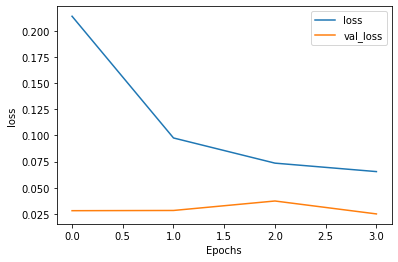

In [ ]:
# Plot training history
plot_graphs(history_us, 'loss')

In [ ]:
# Print accuracy measures
print("\n Evaluating Model ... \n")

predicted = model.predict(X_test_Glove)
predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_test, predicted))
print("\n")
logger = logging.getLogger("logger")
result = compute_metrics(y_test, predicted)
for key in (result.keys()):
    logger.info("  %s = %s", key, str(result[key]))


 Evaluating Model ... 

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     18665
           1       0.37      0.81      0.51       107

    accuracy                           0.99     18772
   macro avg       0.68      0.90      0.75     18772
weighted avg       1.00      0.99      0.99     18772





In [ ]:
# Create dataframe for inspection of results
tmp = pd.DataFrame(X_test, columns=['text'])
tmp['pred'] = predicted
tmp['rule_book'] = y_test.values

# Quick look at predicted positives
print('Check rule-book hit count: ', len(tmp[tmp['rule_book']==1]))

Check rule-book hit count:  107


In [ ]:
# Take a look at predicted positives that did not have a rule-book hit
table = tmp[(tmp['pred']==1) & (tmp['rule_book']==0)]
display(HTML(table.to_html()))
table.to_csv(f'10_performance/model_{focus}_fps.csv')
print(f"\nThere are {len(table)} 'false' positives ...")

,text,pred,rule_book
1068,"location pipeline services dj basindiesel overflow into secondary containment during restocking process by thirdparty fuel transport company no environmental contact incident 40228thirdparty fuel company hired transport haulertruck to restock fuel tanks at project laydown yard as the transport truck operator was pumping diesel into the storage tank he overflowed approximately fifty thousand, one hundred gallons of diesel into the lined secondarycontainment it is important to note the diesel fuel thatoverflowed by the hauler was fullycontained and the secondary containment was properly remediated by the fuel companynofuel diesel in this case ever touched the soil see detailed description",1,0
12085,a small amount of diesel was found to have leaked from a welfare unit which was positioned near c53 euchanhead a small amount of diesel was found to have leaked from a welfare unit which was positioned near c53 euchanhead spill kits were immediately deployed and the spill was contained on the track near where the welfare unit was located a large plant nappy was also positioned under the welfare units generator and fuel tank the contaminated material from the track was placed on visqueen and will be up lifted and disposed of in line with good environmental practiceno water courses were affected by this incident,1,0
21679,cp20210044 env nanjv 80l hydraulic oil an excavator was grubbing off the midgrade ore pad when a rock became stuck in the tracks as operator moved forward the rock impacted a cover plate buckling it which caused the plate to damage the 4inch hydraulic suction line causing 80l of hydraulic oil to be released to the ground work stopped and scene frozen spill pads were immediately placed on spill to contain area cleaned and disposed of contaminated soil,1,0
2005,"water being pumped from underground conduit leaked out of subcontractors vacc truck onto ground approximately twenty gallons work was stopped incident 38211at approximately one thousand, five hundred and thirty a subcontractors vacuum truck was used to vacuum particulate water from underground electrical conduit m1 the vacuum was released to switch over to conduit m2 and it was noticed that water was leaking from the back of the debusk vacuum truck the leak was noticed and stopped immediately resulting in approximately twenty gallons of particulate water being released to the ground the water was sampled for ph and determined to be at six see detailed description",1,0
3677,"adt seven hundred and forty pp106 experienced overflow of diesel due to heat expansion approx 05l diesel leaked out from the breather cap and dripped on the ground incident 34452wpa angore yard adt seven hundred and forty pp106 experienced overflow of diesel due to heat expansion approx 05l diesel leaked out from the breather cap and dripped on the ground the adt was refuelled at 6am this morning approx 40l the adt was parked up in wpa yard and not working where wpa yard what 05lt of diesel to grade when 23th august one thousand, five hundred hrs how fuel tank was over filled which facilitated expansion to occur other refuellers observed spill and cleaned up the machine and contaminated soil further actions refuelling team was stood down and spoke to on importance of not overfilling equipment see detailed description",1,0
9519,small fire on drive pto within ndd truck utilities bay crew members from subcontractor smelled strong odour of burning rubber emanating from services compartment within truck upon opening compartment door saw smoke and small flame escaping pto unit truck shut down immediately crew member used truck compartment dry chemical extinguisher to extinguish flame and cool pto unit rangedale mechanic called to inspect fault is local to pto unit within utilities only truck was operating in carpark area at the time,1,0
65245,inhalation of harmful substancesingle episode an employee was attempting to replace a pressure gauge on a hot gas ammonia line as t


There are 149 'false' positives ...


### Other Methods

#### Cat Boost

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [ ]:
import sklearn.model_selection
import sklearn.metrics
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Use Randomsearchcv to find good hyperparameters.
params = {'depth': [5, 6, 7, 8, 9],
 'learning_rate' : [0.0001, 0.001, 0.005, 0.01, 0.1],
 'l2_leaf_reg': [2, 4, 6, 8],
 'iterations': [100, 200, 300, 400]}
cb = CatBoostClassifier()
cb_model = RandomizedSearchCV(cb, params, verbose=1, cv=3, n_jobs=-1)
cb_model.fit(pd.DataFrame(X_train_Glove), y_train.astype(float), verbose=0)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f4258830e10>,
                   n_jobs=-1,
                   param_distributions={'depth': [5, 6, 7, 8, 9],
                                        'iterations': [100, 200, 300, 400],
                                        'l2_leaf_reg': [2, 4, 6, 8],
                                        'learning_rate': [0.0001, 0.001, 0.005,
                                                          0.01, 0.1]},
                   verbose=1)

In [ ]:
cb_model.best_params_

{'learning_rate': 0.001, 'l2_leaf_reg': 2, 'iterations': 400, 'depth': 6}

In [ ]:
def run_catboost (X, y):
    # split into train and CV data
    n_splits = 5
    splits = list(sklearn.model_selection.StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2019).split(X, y))

    models = []
    scores = np.zeros(n_splits)

    print('Training...')

    for i, (idx_train, idx_cv) in enumerate(splits):
        print(f'\nCV Split {i+1} Confusion Matrix:')
        X_train = X.iloc[idx_train, :]
        y_train = y.iloc[idx_train]

        X_cv = X.iloc[idx_cv, :]
        y_cv = y.iloc[idx_cv]

        # Learning rate is important; large values overfit the data
        model = CatBoostClassifier(learning_rate=0.001, depth=6, l2_leaf_reg=2, od_type='IncToDec',
                                loss_function='Logloss', use_best_model=True, eval_metric='MCC')

        model.fit(X_train, y_train.astype(float), silent=True,
                  eval_set=(X_cv, y_cv.astype(float)))

        y_predict_train = model.predict(X_train)
        y_predict_cv = model.predict(X_cv)

        score_train = sklearn.metrics.matthews_corrcoef(y_train, y_predict_train)
        score_cv = sklearn.metrics.matthews_corrcoef(y_cv, y_predict_cv)

        models.append(model)
        scores[i] = score_cv

        print(sklearn.metrics.confusion_matrix(y_cv, y_predict_cv))
        print('\nRecall: ', round(sklearn.metrics.recall_score(y_cv, y_predict_cv), 2))
        print('Precision: ', round(sklearn.metrics.precision_score(y_cv, y_predict_cv), 2))

        #print('%d %.3f %.3f' % (i, score_train, score_cv))
    
    return(model)
    print('\nCV MCC scores %.3f ± %.3f' % (np.mean(scores), np.std(scores)))

In [ ]:
# Train the CatBoost Model on the base data
catboost_model = run_catboost(X=pd.DataFrame(X_train_Glove_us), y=y_train_us)

Training...

CV Split 1 Confusion Matrix:
[[158  30]
 [ 42  52]]

Recall:  0.55
Precision:  0.63

CV Split 2 Confusion Matrix:
[[151  37]
 [ 29  65]]

Recall:  0.69
Precision:  0.64

CV Split 3 Confusion Matrix:
[[164  24]
 [ 46  48]]

Recall:  0.51
Precision:  0.67

CV Split 4 Confusion Matrix:
[[160  28]
 [ 39  55]]

Recall:  0.59
Precision:  0.66

CV Split 5 Confusion Matrix:
[[156  32]
 [ 28  66]]

Recall:  0.7
Precision:  0.67


In [ ]:
y_predict_test = catboost_model.predict(X_test_Glove)
print(Counter(y_test), '\n')
conf_mat_cb = sklearn.metrics.confusion_matrix(y_test, y_predict_test)
false_alarms = round(100*conf_mat_cb[0, 1] / conf_mat_cb[0, 0], 1)
print(conf_mat_cb)
print('\nRecall: ', round(sklearn.metrics.recall_score(y_test, y_predict_test), 2))
print('Precision: ', round(sklearn.metrics.precision_score(y_test, y_predict_test), 2))
print('F beta: ', round(sklearn.metrics.fbeta_score(y_test, y_predict_test, beta=2), 2))
print(f'False Alarms: {false_alarms}%')

Counter({0: 18665, 1: 107}) 

[[15988  2677]
 [   45    62]]

Recall:  0.58
Precision:  0.02
F beta:  0.1
False Alarms: 16.7%


#### Logistic Regression

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
X_train_Glove_sc = scaler.fit_transform(X_train_Glove)

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train_Glove_sc, y_train)

LogisticRegression(max_iter=3000)

In [ ]:
lr_clf.score(X_test_Glove, y_test)

0.7802578308118474

In [ ]:
y_predicted = lr_clf.predict(X_test_Glove)

In [ ]:
cnf = metrics.confusion_matrix(y_test, y_predicted)
cnf

array([[14590,  4075],
       [   50,    57]])

In [ ]:
lr_recall = round(cnf[1, 1] / (cnf[1, 0] + cnf[1, 1]), 2)
print(f'Logistic regression recall = {lr_recall}')
lr_prec = round(cnf[1, 1] / (cnf[0, 1] + cnf[1, 1]), 2)
print(f'Logistic regression precision = {lr_prec}')

Logistic regression recall = 0.53
Logistic regression precision = 0.01


#### SVM

In [ ]:
from sklearn.svm import OneClassSVM
# Train a one-class SVM 
svm_model =  OneClassSVM(nu = 0.005) # 0.5%
svm_model.fit(pd.DataFrame(X_train_Glove))

OneClassSVM(nu=0.005)

In [ ]:
preds_svm = pd.Series(svm_model.predict(X_test_Glove)).map({1: 0, -1: 1})
preds_svm = pd.DataFrame({'prediction':preds_svm})
preds_svm['rule_book'] = y_test.reset_index(drop=True)
preds_svm[(preds_svm['prediction']==1) & (preds_svm['rule_book']==1)]

,prediction,rule_book
1227,1,1
2751,1,1
2829,1,1
6492,1,1
10474,1,1
17640,1,1
17957,1,1


In [ ]:
# Check metrics
svm_ta = len(preds_svm[(preds_svm['rule_book']==1)])
svm_tp = len(preds_svm[(preds_svm['prediction']==1) & (preds_svm['rule_book']==1)])
svm_fp = len(preds_svm[(preds_svm['prediction']==1) & (preds_svm['rule_book']==0)])
svm_pp = len(preds_svm[(preds_svm['prediction']==1)])

prec = svm_tp/svm_pp
reca = svm_tp/svm_ta

print(f'Precision: {round(prec, 2)}')
print(f'Recall: {round(reca, 2)}')

Precision: 0.01
Recall: 0.07
